# Visionizer

In [44]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import collections
import random
import pickle
import h5py
import copy
import os
import time
import json
import re
from operator import itemgetter

from PIL import Image
from tqdm import tqdm

MAX_SEQ_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_SIZE = 100
embedding_dim = 256
units = 512

! pip install gensim==4.1.2
import gensim.downloader as gloader

# Load Drive

In [2]:
try:
    from google.colab import drive

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("We're running Colab")
    # Mount the Google Drive at mount
    mount = '/content/gdrive'
    print("Colab: mounting Google drive on ", mount)
    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    drive_root = mount + "/My Drive/NLP/Visionizer"

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
        print("\nColab: making sure ", drive_root, " exists.")
        os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    % cd $drive_root

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/NLP/Visionizer  exists.

Colab: Changing directory to  /content/gdrive/My Drive/NLP/Visionizer
/content/gdrive/My Drive/NLP/Visionizer


# Load Dataset

100%|██████████| 32528/32528 [00:14<00:00, 2215.20it/s]


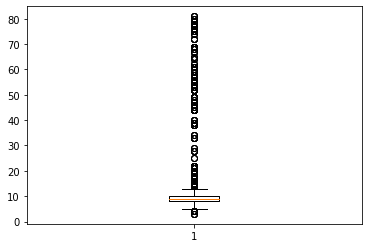

In [3]:
s_lens = []

def clean_captions(sentences):
    cleaned = []
    for s in tqdm(sentences):
        # run the subs in this exact order, or remember to pay attention
        sen = s[0].decode('ISO-8859-1').lower()
        sen = re.sub(r'\.', ' ,', sen)
        sen = '<start> ' + sen + '<end>'
        sen = re.sub(',<end>', ' <end>', sen)
        sen = re.sub('<br>', ' ', sen)
        sen = re.sub(' +', ' ', sen)
        sen = re.sub('(\w)<end>', '\1 <end>', sen)
        sen = re.sub(',(\w)', ', \1', sen)
        sen = re.sub('(\w),', '\1 ,', sen)
        sen = re.sub(r'[^\w\s,\-<>]', '', sen)
        sen = re.sub('-', ' ', sen)
        sen = re.sub(r',.+<end>', '<end>', sen) # consider only first comma comment
        sen = sen.lower()
        cleaned.append(sen)
        s_lens.append(len(sen.split()))
    return cleaned


dataset = h5py.File("dataset/fashiongen_256_256_validation.h5", 'r')
cleaned_captions = clean_captions(dataset['input_description'])

plt.boxplot(s_lens)
plt.show()

In [4]:
% cd /content

/content


In [5]:
! mkdir dataset
! mkdir dataset/np_files
! mkdir dataset/raw_merged_val_512_512

In [6]:
! ls
! ls dataset

dataset  gdrive  sample_data
np_files  raw_merged_val_512_512


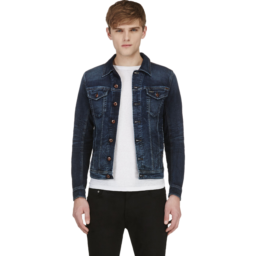

<start> denim like jogg jacket in blue <end>


In [7]:
img = Image.fromarray(dataset['input_image'][0])
display(img)
print(cleaned_captions[0])

# Load InceptionV3 pretrained weights

In [8]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [9]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

# Save Images as .jpg

In [10]:
'''
input_images = dataset['input_image']
for j in tqdm(4 * np.arange(len(input_images)//4)):
    img1 = np.hstack((input_images[j], input_images[j + 1]))
    img2 = np.hstack((input_images[j + 2], input_images[j + 3]))
    img = Image.fromarray(np.vstack((img1, img2)))
    img.save(f"dataset/raw_merged_val_512_512/{j//4}.jpg")
'''

input_images = dataset['input_image']
j=0
for img in tqdm(input_images):
    img = Image.fromarray(img)
    img.save(f"dataset/raw_merged_val_512_512/{j}.jpg")
    j+=1

100%|██████████| 32528/32528 [03:21<00:00, 161.71it/s]


In [11]:
number_of_images = len(os.listdir("dataset/raw_merged_val_512_512"))
print(number_of_images)

32528



# Save outputs after InceptionV3 inference

In [12]:
img_paths = ["dataset/raw_merged_val_512_512/" + str(i) + '.jpg' for i in range(number_of_images)]
img_name_vector = []

image_dataset = tf.data.Dataset.from_tensor_slices(img_paths)
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

i = 0
for img in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for batch_i, bf in enumerate(batch_features):
        img_name_vector.append(f"dataset/np_files/{i}.npy")
        np.save(img_name_vector[-1], bf.numpy())
        i += 1

100%|██████████| 1017/1017 [06:07<00:00,  2.77it/s]


In [13]:
print(len(os.listdir("dataset/np_files")))

32528


# Tokenizer (Class)

In [134]:
class Tokenizer(object):
    def __init__(self, dataset_sentences, embedding_dim, glove_dict, glove_matrix):
        """
            dataset_sentences : sentences to be tokenized in form of strings
            embedding_dim : size of the embeddings
            glove_dict : glove dictionary
            glove_matrix : glove matrix
        """
        self.embedding_matrix = None
        #word to token dictionary
        self.value_to_key = {}
        #useful for implementation, contains only new OOV terms
        self.value_to_key_new = {} 
        self.num_unique_words = 0
        #word to token
        self.key_to_value = {} 
        self.dataset_sentences = dataset_sentences 
        self.embedding_dim = embedding_dim
        self.glove_dict = glove_dict
        self.glove_matrix = glove_matrix 
        #set containing all the words of the vocabulary, update after the processing of each split
        self.unique_words = set()

    def get_val_to_key(self):
        return copy.deepcopy(self.value_to_key)

    def tokenize(self):
        """
            create and/or upload tokenizer. Each time that a new word is passed
            from a sentence, check if it has already been tokenized otherwise 
            tokenize it and add to the vocabulary. 
        """
        self.value_to_key_new = {}
        unique_words = set()
        for sen in self.dataset_sentences:
            for w in sen.split():
                # get set of unique words
                unique_words.add(w)  
        #new unique are the words not still processed
        new_unique = unique_words - self.unique_words 
        for i, word in enumerate(new_unique):
            #it means we are in the validation or test set, the embedding has already been created and updated by the train
            if self.embedding_matrix is not None: 
                #tokenization
                self.key_to_value[i + len(self.embedding_matrix)] = word  
                self.value_to_key[word] = i + len(self.embedding_matrix)
            else:
                #first time we are tokenizing (train), don't need to add len
                self.key_to_value[i] = word 
                self.value_to_key[word] = i
            self.value_to_key_new[word] = i

        self.num_unique_words = len(new_unique)
        #update unique words with new unique
        self.unique_words = self.unique_words | new_unique  

    def __build_embedding_matrix_glove(self):
        """
            create the embedding matrix. The rows corresponding to the words
            contained in glove will be filled. If a word is not in glove the
            word and its index are saved in order to be processed later.   
        """
        oov_words = []
        tmp_embedding_matrix = np.zeros((self.num_unique_words, self.embedding_dim)) #dtype=np.float32
        len_old_emb_matrix = len(self.embedding_matrix) if self.embedding_matrix is not None else 0
        for word, idx in tqdm(self.value_to_key_new.items()):
            try:
                embedding_vector = self.glove_matrix[self.glove_dict[word]]
                #create tmp embedding matrix to be concatenated to the original embedding matrix
                tmp_embedding_matrix[idx] = embedding_vector 
            except (KeyError, TypeError):
                oov_words.append((word, idx + len_old_emb_matrix))
        
        if self.embedding_matrix is not None:
            #concatenate old embedding matrix and new one (new OOVs)
            self.embedding_matrix = np.vstack((self.embedding_matrix, tmp_embedding_matrix)) 
        else:
            self.embedding_matrix = copy.deepcopy(tmp_embedding_matrix)
        return oov_words


    def build_embedding_matrix(self):
        """
            create embedding vector for OOV words. If a word 
            is out of vocabulary values follow uniform distribution . 
        """
        oov_words = self.__build_embedding_matrix_glove()
        for word, idx in oov_words:
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=self.embedding_dim)
            self.embedding_matrix[idx] = embedding_vector
        return copy.deepcopy(self.embedding_matrix)

## Preprocess and tokenize the captions

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words (to save memory).
* Tokenize all captions by mapping each word to it's index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [135]:
print(img_name_vector)

['dataset/np_files/0.npy', 'dataset/np_files/1.npy', 'dataset/np_files/2.npy', 'dataset/np_files/3.npy', 'dataset/np_files/4.npy', 'dataset/np_files/5.npy', 'dataset/np_files/6.npy', 'dataset/np_files/7.npy', 'dataset/np_files/8.npy', 'dataset/np_files/9.npy', 'dataset/np_files/10.npy', 'dataset/np_files/11.npy', 'dataset/np_files/12.npy', 'dataset/np_files/13.npy', 'dataset/np_files/14.npy', 'dataset/np_files/15.npy', 'dataset/np_files/16.npy', 'dataset/np_files/17.npy', 'dataset/np_files/18.npy', 'dataset/np_files/19.npy', 'dataset/np_files/20.npy', 'dataset/np_files/21.npy', 'dataset/np_files/22.npy', 'dataset/np_files/23.npy', 'dataset/np_files/24.npy', 'dataset/np_files/25.npy', 'dataset/np_files/26.npy', 'dataset/np_files/27.npy', 'dataset/np_files/28.npy', 'dataset/np_files/29.npy', 'dataset/np_files/30.npy', 'dataset/np_files/31.npy', 'dataset/np_files/32.npy', 'dataset/np_files/33.npy', 'dataset/np_files/34.npy', 'dataset/np_files/35.npy', 'dataset/np_files/36.npy', 'dataset/n

In [136]:
#remove photos with a caption len higher than 20

for i, c in enumerate(cleaned_captions):
    if len(c.split()) > 20:
      img_name_vector.pop(i)
      cleaned_captions.pop(i)

print(len(img_name_vector), len(cleaned_captions))

32190 32190


In [137]:
# Load Glove Embeddings from a pickle file or download if necessary
try:
    with open(f"glove-{EMBEDDING_SIZE}.pkl", 'rb') as f:
        emb_model = pickle.load(f)
except Exception:
    emb_model = gloader.load(f"glove-wiki-gigaword-{EMBEDDING_SIZE}")
    with open(f"glove-{EMBEDDING_SIZE}.pkl", 'wb') as f:
        pickle.dump(emb_model, f)
####################################################################

glove_dict = emb_model.key_to_index
glove_matrix = emb_model.vectors

try:
    with open("emb_mat.pkl", 'rb') as f:
        emb_matrix = pickle.load(f)
    with open("word_to_index.pkl", 'rb') as f:
        val_to_key = pickle.load(f)
    with open(f"tokenizer.pkl", 'rb') as f:
        tokenizer = pickle.load(f)
except Exception as e:
    tokenizer = Tokenizer(cleaned_captions, EMBEDDING_SIZE, glove_dict, glove_matrix)
    tokenizer.tokenize()
    emb_matrix = tokenizer.build_embedding_matrix()
    emb_matrix = np.vstack((np.zeros((1, EMBEDDING_SIZE)), emb_matrix))

    val_to_key = tokenizer.get_val_to_key()
    with open(f"emb_mat.pkl", 'wb') as f:
        pickle.dump(emb_matrix, f)
    with open(f"word_to_index.pkl", 'wb') as f:
        pickle.dump(word_to_index, f)
    with open(f"tokenizer.pkl", 'wb') as f:
        pickle.dump(tokenizer, f)

# Shifts tokens by 1 because of padding (to adapt to the network embedding layer)
val_to_key.update((x, y + 1) for x, y in val_to_key.items())

# Translation dictionary to retranslate from tokens to words
key_to_val = {}
key_val_list_items = list(tokenizer.key_to_value.items())
for i, (token, value) in enumerate(key_val_list_items):
    if i > 0:
        key_to_val[token] = key_val_list_items[i - 1][1]
    else:
        key_to_val[i] = '<PAD>'


def word_to_index(word):
    return val_to_key[word]


def index_to_word(index):
    return key_to_val[index]

100%|██████████| 1670/1670 [00:00<00:00, 256368.04it/s]


In [138]:
# Create the tokenized vectors
cap_vector =[]
for sen in cleaned_captions:
    cap_vector.append([word_to_index(i) for i in sen.split()])

## Split the data into training and testing

In [139]:
img_to_cap_vector = {}
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img] = cap
# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
#random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  img_name_train.append(imgt)
  img_to_cap_vector[imgt] = img_to_cap_vector[imgt] + ([0]*(MAX_SEQ_LEN-len(img_to_cap_vector[imgt])))
  cap_train.append(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  img_name_val.append(imgv)
  img_to_cap_vector[imgv] = img_to_cap_vector[imgv] + ([0]*(MAX_SEQ_LEN-len(img_to_cap_vector[imgv])))
  cap_val.append(img_to_cap_vector[imgv])

In [140]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(25752, 25752, 6438, 6438)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [141]:
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [142]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8'))
  return img_tensor, cap

In [143]:
print(img_name_train[0])
print([index_to_word(i) for i in cap_train[0]])
print(np.array(cap_train).shape)
print(len(cap_train))

dataset/np_files/0.npy
['<start>', 'denim', 'like', 'jogg', 'jacket', 'in', 'blue', '<end>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
(25752, 20)
25752


In [144]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [145]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [146]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [147]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, units, word_to_index, embedding_matrix):
    super(RNN_Decoder, self).__init__()
    self.word_to_index = word_to_index
    self.embedding_matrix = embedding_matrix
    self.vocab_size = len(self.word_to_index.keys()) + 1
    self.units = units
    self.embedding = tf.keras.layers.Embedding(input_dim=self.vocab_size,
                                     output_dim= EMBEDDING_SIZE,
                                     input_length=MAX_SEQ_LEN,
                                     mask_zero=True,
                                     weights=[self.embedding_matrix],
                                     trainable=False
                                     ) 
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(self.vocab_size)
    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)
    #probs = tf.reshape(x, (-1, MAX_SEQ_LEN, self.vocab_size))
    probs = tf.nn.softmax(x)
    

    return x, state, attention_weights, probs

#BEAM, CLASSIFICATION (CATEGORIE), TRANSLATION

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [158]:
encoder = CNN_Encoder(EMBEDDING_SIZE)
decoder = RNN_Decoder(units, val_to_key, emb_matrix)

In [149]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [150]:
%cd gdrive/MyDrive/NLP/Visionizer/

/content/gdrive/MyDrive/NLP/Visionizer


In [151]:
! ls

checkpoints  dataset


In [152]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [153]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [154]:
%cd /content
! cp -r gdrive/MyDrive/NLP/Visionizer/checkpoints /content

/content


## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [155]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [159]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _, probs = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [160]:
EPOCHS = 3

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 3 Batch 0 Loss 2.9070
Epoch 3 Batch 100 Loss 0.8367
Epoch 3 Batch 200 Loss 0.9061
Epoch 3 Batch 300 Loss 0.6901
Epoch 3 Batch 400 Loss 0.6897
Epoch 3 Loss 0.947106
Time taken for 1 epoch 304.28 sec



In [161]:
! cp -r ./checkpoints/train gdrive/MyDrive/NLP/Visionizer/checkpoints/

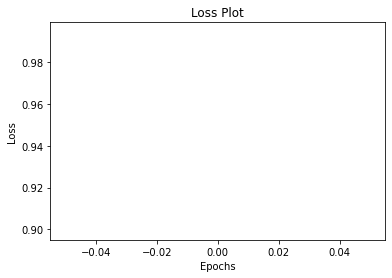

In [162]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [163]:
def predict(sent_predict, features, hidden):
    '''
    ::params
    src_input: sequence generated at this point
    features: image features extracted
    '''
    predictions, hidden, attention_weights, probs = decoder(sent_predict,
                                         features,
                                         hidden)
    return hidden, probs[0][0]

In [ ]:
def beam_search(features, beam_size=2, top_k=2, sequence_max_len=MAX_SEQ_LEN):
    #1) struttura appoggio: k_beam = [(0, [0]*(sequence_max_len+1))]
    #1bis) fare il logaritmo delle probabilità
    #2) aprire di k fino a generare frasi che terminano con <end> o sequence max len
    #3) normalizzare (dividere per la lunghezza)
    #4) ritornare il migliore beam

    # (probability, sequence(initialize_of_zeros))
    k_beams_running = [(0, [word_to_index('<start>')]) for i in range(beam_size)] #2
    #initialize running k-beams
    k_beams_ended = [] 
    #initialize list to store ended k-beams
    hiddens = [decoder.reset_state(batch_size=1) for i in range(beam_size)]
    #initialize hiddens for each beam

    while beam_size > 0:
        list_of_beams = []
        for beam in range(beam_size):
            hiddens[beam], probs = predict(tf.expand_dims(k_beams_running[beam][1], 0), features, hiddens[beam])
            print(probs)
            predicted = tf.math.top_k(tf.math.log(probs), k=top_k)
            top_k_indices = predicted.indices.numpy()
            top_k_logprobs = predicted.values.numpy()  
            # adding temporary sums for logprobs
            for i in range(top_k):
                list_of_beams.append((k_beams_running[beam][0] + top_k_logprobs[i], k_beams_running[beam][1] + top_k_indices[i]))
            print(list_of_beams)
        for beam in range(beam_size):
            max_s = max(list_of_beams,key=itemgetter(0))
            k_beams_running[beam] = max_s
            list_of_beams.remove(max_s)
            if k_beams_running[beam][1][-1] == word_to_index('<end>') \
                or len(k_beams_running[beam][1]) >= sequence_max_len:
                k_beams_ended.append(k_beams_running[beam])
                k_beams_running.remove(k_beams_running[beam])
                hiddens.remove(hiddens[beam])
                beam_size -= 1

    #normalize
    for sen in k_beams_ended:
        sen[0] = sen[0] / len(sen[1])
    return max(k_beams_ended,key=itemgetter(0))[1]

In [ ]:
def beam_search_evaluate(image_features_path):
    img_tensor_val = np.load(image_features_path)
    features = encoder(img_tensor_val)
    image_caption = [index_to_word(i) for i in beam_search(features)]
    print(image_caption)

In [171]:
def evaluate(image_features_path):
    attention_plot = np.zeros((MAX_SEQ_LEN, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    img_tensor_val = np.load(image_features_path)

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(MAX_SEQ_LEN):
        predictions, hidden, attention_weights, probs = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id))
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [165]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [166]:
print((os.listdir('dataset/np_files')[:10]))


['31103.npy', '7691.npy', '19269.npy', '21662.npy', '4737.npy', '6649.npy', '24025.npy', '29716.npy', '18854.npy', '7912.npy']


dataset/np_files/27499.npy
Real Caption: <start> long sleeve stretch jersey pullover in burnt red <end>
Prediction Caption: panelled rib knit wool cashmere blend sweatshirt in black <end>


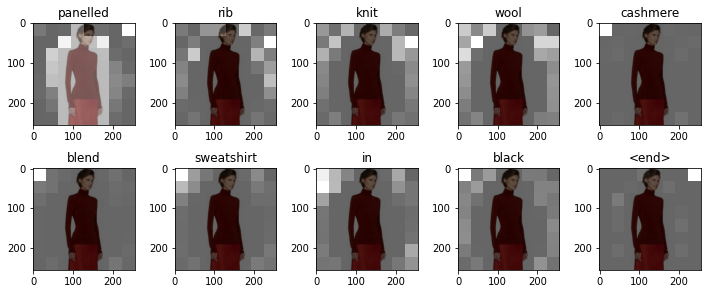

In [175]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
number = int(re.sub(r'[^\d]', '', image))
real_caption = ' '.join([tf.compat.as_text(index_to_word(i))
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(f'dataset/raw_merged_val_512_512/{number}.jpg', result, attention_plot)

In [ ]:
beam_search_evaluate(image)

InvalidArgumentError: ignored